## Metrics Choices

In choosing a metric, I want to consider that this a low stakes categorization. However, it does have the potential to sensitive or uncomfortable because we're talking about people's personal relationships. In this sense, I think that in prioritizning predicitons it's almost assuming some sort of heigherarchy of relationship status. Why is it harmful to predict somebody is single or divorced when they're actually married unless it considered inherently better to be married? 

I think that especially across three categorical variables, I'm more interested in overall accuracy, each class's error rate, or the f_beta score. While there is some imbalance in the data, it's not strong, so I don't think that precision, recall, or f1 scores are necessary. Rather, the goal is just to know whether we got our data right. 

**use class-weighted accuracy** for each ML algorithm. 
https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd 

In [3]:
#import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#preprocessing tools
from sklearn.model_selection import StratifiedKFold, KFold, ParameterGrid, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder

#models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#metrics
from sklearn.metrics import balanced_accuracy_score, make_scorer, mean_squared_error, log_loss

In [4]:
#read in data set and print
df = pd.read_csv('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/data/data_edit2.csv', delimiter=',')
df.head()
print(df['engnat'])

0        2
1        1
2        1
3        2
4        1
        ..
26036    2
26037    1
26038    2
26039    1
26040    2
Name: engnat, Length: 26041, dtype: int64


## Calcualte Baseline Accuracy 

We know that the accuracy is defined as the true positives and true negatives divided by all of the true and false components of the confusion matrix. However, currently married (the most populous class) will be predicted for all points when we develop the baseline. This means that true negatives and false negatives go to zero. This leaves the equation as  A = TP/(TP+FP). 

In [34]:
#CALCULATE BASELINE ACCURACY
df = df.loc[:, df.columns != 'major']
y_base = df.loc[:,'married']

y1 = df.loc[:500,'married']
X1 = df.loc[:500, df.columns != 'married'] # all other columns are features  


def accuracy_baseline(y):
    '''calculate baseline accuracy for multiclass problem'''
    TP = np.bincount(np.asarray(y))[2]/len(y) #currently married is most populous class
    print('fraction of most populous class. ', TP)
    
    preds = np.ones(len(y))#predict all points as class as married
    score = balanced_accuracy_score(y,preds)
    return score

print(accuracy_baseline(y_base)) #accuracy baseline for all data
print(accuracy_baseline(y1)) #accuracy baseline for subset

fraction of most populous class.  0.480741906992819
0.3333333333333333
fraction of most populous class.  0.44510978043912175
0.3333333333333333


## Preprocessing Setup 
### subset of data for initial modeling

In [20]:
#DETERMINE ENCODERS
#most everything is already encodeded and bounded in a range
#categorical - questions that are answered on likert
onehot_ft = ['race', 'voted','familysize','urban', 'gender', 'engnat', 'orientation','hand', \
             'religion','voc_fake', 'voc_conf']
minmax_ft = ['Mscore', 'age','Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', \
             'Q9A', 'Q10A','Q11A', 'Q12A', 'Q13A', 'Q14A','Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A',\
             'education', 'extraver', 'agreeable', 'conscient', 'neuroticism', 'openness']                
stnd_ft = ['testelapse','PITtime', 'NITtime', 'PVHtime','CVHtime']    


For the sake of quicker turn arounds, I'm going to pull a very small subset from my code through randomly sampling the data.

In [21]:
#DEFINE FULL SET OF X and y as features and target
y_full = df.loc[:,'married']
X_full = df.loc[:, df.columns != 'married'] # all other columns are features    

#SET RANDOM STATE IN FUNCTION
random_state = 77

# collect all the encoders
preprocess = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ft),
        ('minmax', MinMaxScaler(), minmax_ft),
        ('std', StandardScaler(), stnd_ft)
    ])

# FOR USE IN XGBOOST
print(type(y1))
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y1)
label_encoded_y = pd.Series(label_encoder.transform(y1))
print(type(label_encoded_y))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Define a function for models: splitting method and metric (accuracy)

In [97]:
def MLpipe_StrKFold_accuracy(X, y, preprocessor, ML_algo, param_grid, random):
    '''
    This function splits the data through stratified kfold splitting. it usess a preprocessor defined
    above to traverse the hyperparameters and find the best model given the accuracy score. 
    '''
    
    #SPLITTING STRATEGY#
    # use KFold with 4 folds
    splitter = StratifiedKFold(n_splits=4,shuffle=True, random_state = random)
    
    for train_index, other_index in splitter.split(X1, label_encoded_y):
        #split into train and other
        X_train, X_other = X1.iloc[train_index], X1.iloc[other_index]
        y_train, y_other = label_encoded_y[train_index], label_encoded_y[other_index]
        #split into validation and test
        for val_index, test_index in splitter.split(X_other,y_other):
            X_val, X_test = X1.iloc[val_index], X1.iloc[test_index]
            y_val, y_test = label_encoded_y[val_index], label_encoded_y[test_index]
    
        #preprocess the data and perform cross validation
        pipe = make_pipeline(preprocessor,ML_algo)

        # GridSearchCV loops through all parameter combinations
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring = 'balanced_accuracy',
                            return_train_score = True, n_jobs=-1, verbose=True)


        # fit the model on the training data
        grid.fit(X_train, y_train)

        # save results into a data frame
        results = pd.DataFrame(grid.cv_results_)

        #print('best model parameters:',grid.best_params_)
        print('validation accuracy score:',grid.best_score_) # this is the mean validation score over all iterations
        # save the model & test scores
        best_models = []
        best_params = []
        best_models.append(grid.best_estimator_)
        best_params.append(grid.best_params_)


        # calculate and save the test score
        test_scores = grid.score(X_test, y_test)
        pred_scores = [y_test, grid.best_estimator_.predict(X_test)]
        print('test score:',test_scores)
        return grid, best_models, X_test, test_scores, pred_scores


#### Logistic Regression

First we apply the simpler classification algorithm in logistic regression. The parameter uses an l2 penalty. If this model performs well compared to the others, it would be worth exploring whether or not we should implement elasticnet or an l1 penalty

I set up the hyperparameters and the algorithm. 

In [94]:
#PARAMETERS
# all parameters not specified here will be the default
param_grid_log = {
              'logisticregression__C': np.logspace(-3,2,10)#alpha constitutes C
              } 
#init classifier
clf_lr = LogisticRegression(penalty = 'l2', max_iter = 8000, solver = 'saga')

Something to note here is that I'm using a very small subset of the data. 0.523 is the value of the baseline so we're still doing okay with such a small sample size

Ideally, we would be able to set up multiple runs of the model and take the average of those scores. It is somewhat time expensive for this computer, though. The solution, I think is to use a small number of random states (3-5) and save those results into arrays via pickle. 

In [98]:
#establish set of random states to be used across models
states = [31*i for i in range(1,6)]
print(states)

best_grids_log = []
Xtests_log = []
testscores_log = []
for s in states:
    '''write a forloop that extracts the outputs from 5 runs of algorithm.
    put these values into arrays'''
    grid, best_models, Xtest, testscores, pred_log = MLpipe_StrKFold_accuracy(X1,y1,preprocess,clf_lr,param_grid_log, s)
    best_grids_log.append(grid)
    Xtests_log.append(Xtest)
    testscores_log.append(testscores)
    print(grid.best_params_)
    

print('Balanced Accuracy:',np.around(np.mean(testscores_log),2),'+/-',np.around(np.std(testscores_log),2))

[31, 62, 93, 124, 155]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.4197519056832782
test score: 0.6333333333333333
{'logisticregression__C': 0.5994842503189409}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.43406425999563253
test score: 0.601010101010101
{'logisticregression__C': 2.1544346900318843}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.41300932908776045
test score: 0.6687830687830688
{'logisticregression__C': 27.825594022071257}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.41545642447603226
test score: 0.7032828282828283
{'logisticregression__C': 2.1544346900318843}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.46723507066644326
test score: 0.5708333333333333
{'logisticregression__C': 27.825594022071257}
Balanced Accuracy: 0.64 +/- 0.05


In [99]:
# save the outputs of the models 
import pickle
file = open('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/results/log_model_output.save', 'wb')
pickle.dump((grid, Xtest, testscores, pred_log),file)

file.close()

#### Random Forest

In [100]:
#PARAMETERS
# all parameters not specified here will be the default
param_grid_rf = {
              'randomforestclassifier__max_depth': [1, 5, 20, 100, 300], # the max_depth should be smaller or equal than the number of features roughly
              'randomforestclassifier__max_features': [0.5,0.6,0.7,0.8,0.9,1.0] # linearly spaced between 0.5 and 1
              } 

In [101]:
#ITERATE OVER SEVERAL RANDOM STATES
best_grids_rf = []
Xtests_rf = []
testscores_rf = []
for s in states:
    '''write a forloop that extracts the outputs from 5 runs of algorithm.'''
    grid, best_models, Xtest, testscores, pred_rf = MLpipe_StrKFold_accuracy(X1,y1,preprocess,RandomForestClassifier(s),param_grid_rf, s)
    best_grids_rf.append(grid)
    Xtests_rf.append(Xtest)
    testscores_rf.append(testscores)
    print(grid.best_params_)

print('Balanced Accuracy:',np.around(np.mean(testscores_rf),2),'+/-',np.around(np.std(testscores_rf),2))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
validation accuracy score: 0.4533240905789925
test score: 0.4388888888888889
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 1.0}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
validation accuracy score: 0.42951140362905066
test score: 0.8863636363636364
{'randomforestclassifier__max_depth': 300, 'randomforestclassifier__max_features': 0.8}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
validation accuracy score: 0.4635888294711824
test score: 0.6656084656084656
{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.7}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
validation accuracy score: 0.4539253774547892
test score: 0.8472222222222222
{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__max_features': 1.0}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
validation accuracy score: 0.4646

In [102]:
# save the outputs of the models 
import pickle
file = open('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/results/rf_model_output.save', 'wb')
pickle.dump((grid, Xtest, testscores, pred_rf),file)

file.close()

#### K Nearest Neighbors

In [103]:
#PARAMETERS
# all parameters not specified here will be the default

param_grid_knn = {
              'kneighborsclassifier__n_neighbors':[1,5,10,30,80], 
              'kneighborsclassifier__weights': ['uniform', 'distance'] 
              } 

clf_knn = KNeighborsClassifier()


In [104]:
#ITERATE OVER SEVERAL RANDOM STATES
best_grids_knn = []
Xtests_knn = []
testscores_knn = []
for s in states:
    '''write a forloop that extracts the outputs from 5 runs of algorithm.'''
    grid, best_models, Xtest, testscores, pred_knn = MLpipe_StrKFold_accuracy(X1,y1,preprocess,clf_knn,param_grid_knn, s)
    best_grids_knn.append(grid)
    Xtests_knn.append(Xtest)
    testscores_knn.append(testscores)
    print(grid.best_params_)
    
print('Balanced Accuracy:',np.around(np.mean(testscores_knn),2),'+/-',np.around(np.std(testscores_knn),2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.38280187495873763
test score: 0.4611111111111111
{'kneighborsclassifier__n_neighbors': 80, 'kneighborsclassifier__weights': 'uniform'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.41607858372564255
test score: 0.8282828282828283
{'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.4012853903540178
test score: 0.8338624338624339
{'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.3928857326406346
test score: 0.5568181818181818
{'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
validation accuracy score: 0.43774857676818

In [105]:
#TRAIN TEST SPLIT PROPORTIONS
splitter = StratifiedKFold(n_splits=4,shuffle=True, random_state = 6)
for train_index, other_index in splitter.split(X1, label_encoded_y):
    #split into train and other
    X_train, X_other = X1.iloc[train_index], X1.iloc[other_index]
    y_train, y_other = label_encoded_y[train_index], label_encoded_y[other_index]
    #split into validation and test
    for val_index, test_index in splitter.split(X_other,y_other):
        X_val, X_test = X1.iloc[val_index], X1.iloc[test_index]
        y_val, y_test = label_encoded_y[val_index], label_encoded_y[test_index]
        
print(len(y_train)/len(label_encoded_y))
print(len(y_test)/len(label_encoded_y))
print(len(y_val)/len(label_encoded_y))

0.7504990019960079
0.06187624750499002
0.18762475049900199


In [106]:
# save the outputs of the models 
import pickle
file = open('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/results/knn_model_output.save', 'wb')
pickle.dump((grid, Xtest, testscores, pred_knn),file)

file.close()

Let's try some more advanced techniques to see if we can get further. The overall goal would probably be something like 65-70 accuracy, but unsure if that's possible. 

https://datascience.stackexchange.com/questions/16904/gbm-vs-xgboost-key-differences

It might be better to try xgboost rather than gradient boosting? 

https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn 


XGBoost Documentation
https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn

helpul stackoverflow
https://stackoverflow.com/questions/66097701/how-can-i-fix-this-warning-in-xgboost

#### Gradient Boosting

I want to try gradient boosting just straight up with for loops to get an idea of what I'm dealing with. Then I'll try to hypertune the parameters.

In [205]:
def plot_error():
    y_pred = xgb_cl.predict(X_test_prep)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = balanced_accuracy_score(y_test, predictions)
    print("Balanced Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = xgb_cl.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    
    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.xlabel('Number of Trees')
    pyplot.title('Validation vs Train: XGBoost Log Loss')
    pyplot.show()
    
    
    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    pyplot.ylabel('Error')
    pyplot.xlabel('Number of Trees')
    pyplot.title('Validation vs Train: XGBoost Classification Error')
    pyplot.show()

validation accuracy 0.8329422590292155
test accuracy 0.8857142857142857
Balanced Accuracy: 88.57%


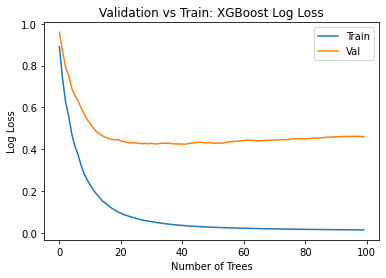

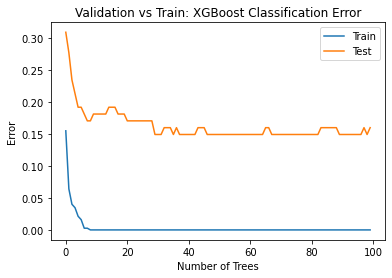

validation accuracy 0.8323080113361443
test accuracy 0.8736772486772487
Balanced Accuracy: 87.37%


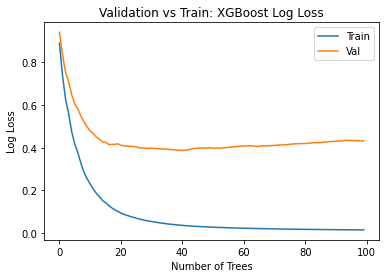

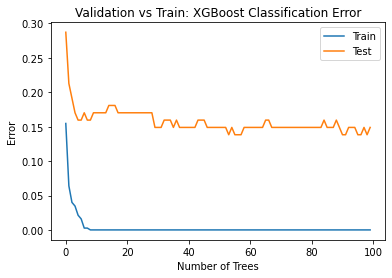

validation accuracy 0.8899456521739131
test accuracy 0.7047619047619048
Balanced Accuracy: 70.48%


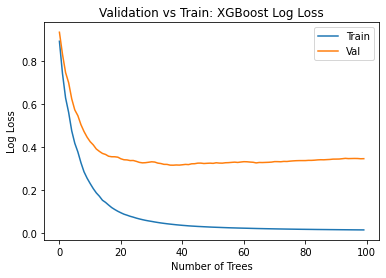

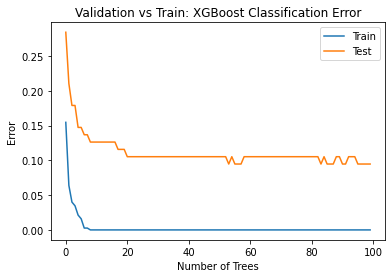

validation accuracy 0.8054763664519763
test accuracy 0.9259259259259259
Balanced Accuracy: 92.59%


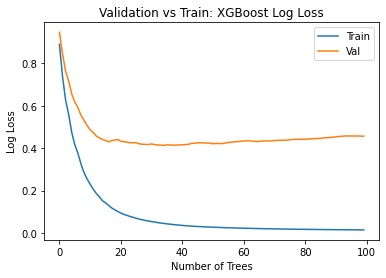

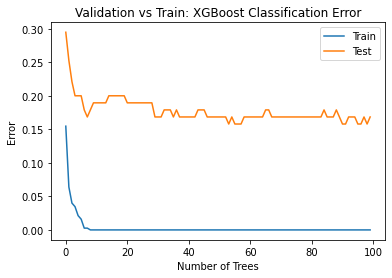

validation accuracy 0.8401544401544402
test accuracy 0.8005698005698006
Balanced Accuracy: 80.06%


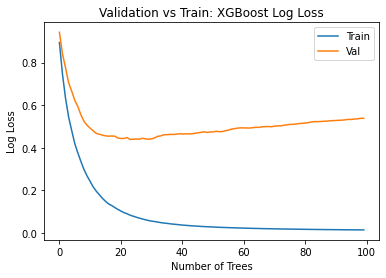

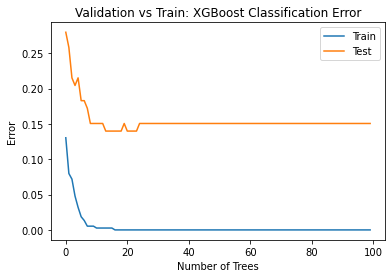

validation accuracy 0.840948090948091
test accuracy 0.7804232804232804
Balanced Accuracy: 78.04%


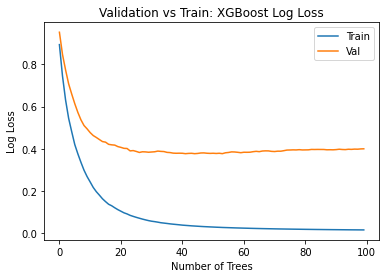

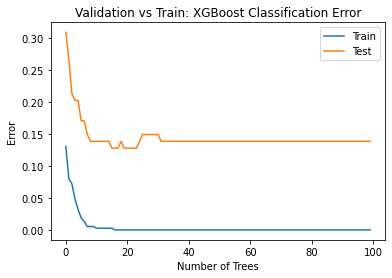

validation accuracy 0.7815476190476192
test accuracy 0.9410256410256411
Balanced Accuracy: 94.10%


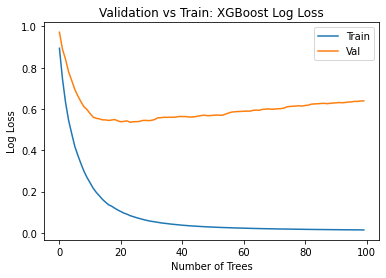

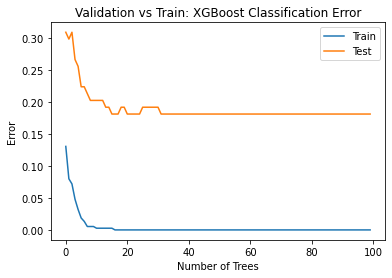

validation accuracy 0.8237327188940092
test accuracy 0.7634920634920634
Balanced Accuracy: 76.35%


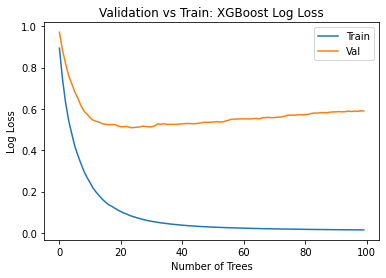

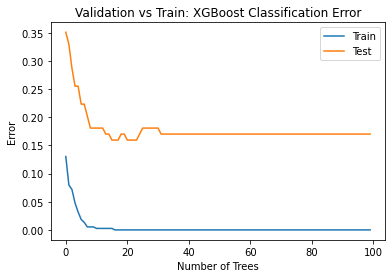

validation accuracy 0.8900112233445568
test accuracy 0.9248366013071895
Balanced Accuracy: 92.48%


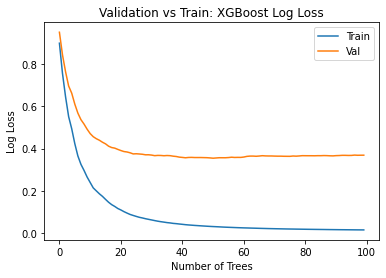

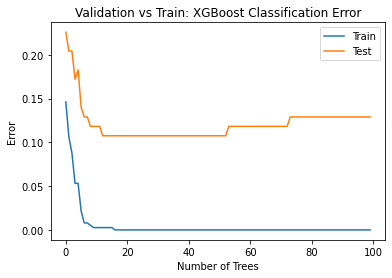

validation accuracy 0.898534214323688
test accuracy 0.883838383838384
Balanced Accuracy: 88.38%


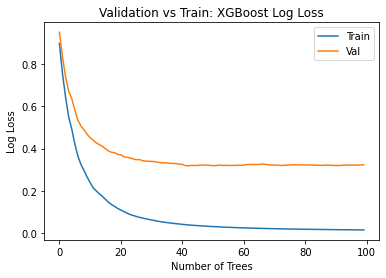

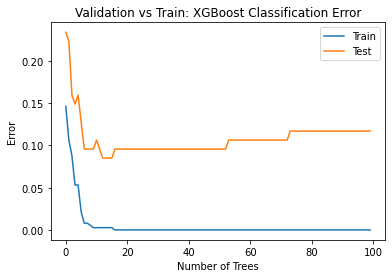

validation accuracy 0.907008547008547
test accuracy 0.7393939393939394
Balanced Accuracy: 73.94%


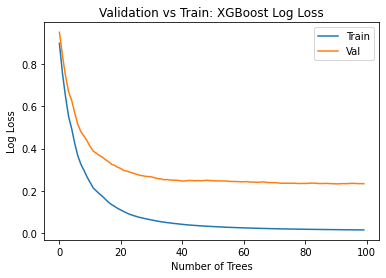

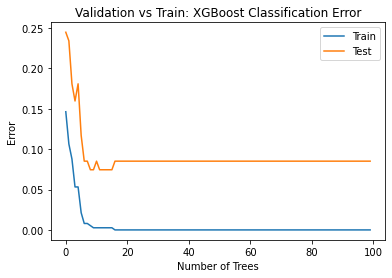

validation accuracy 0.8514769830559304
test accuracy 0.9696969696969697
Balanced Accuracy: 96.97%


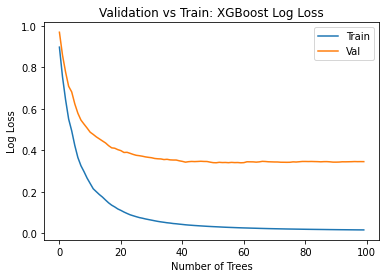

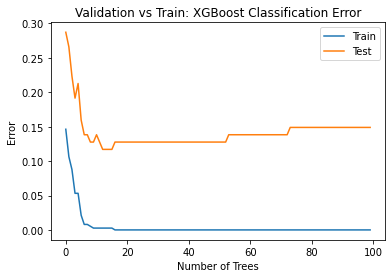

validation accuracy 0.8841298953500917
test accuracy 0.8679653679653679
Balanced Accuracy: 86.80%


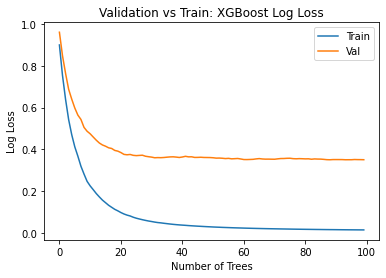

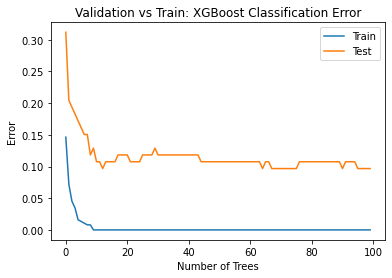

validation accuracy 0.8821428571428571
test accuracy 0.7999999999999999
Balanced Accuracy: 80.00%


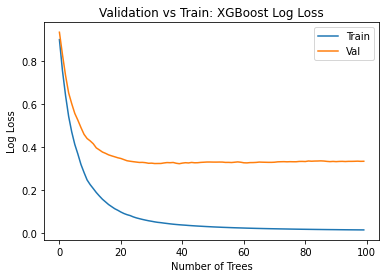

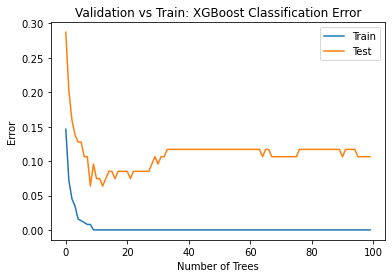

validation accuracy 0.8568736141906874
test accuracy 0.9296296296296296
Balanced Accuracy: 92.96%


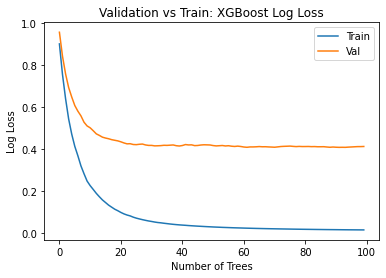

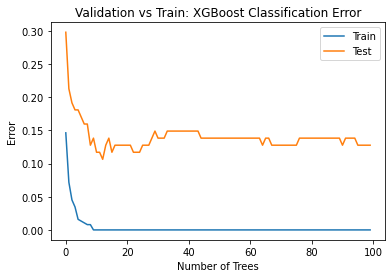

validation accuracy 0.8866229583620888
test accuracy 0.8455026455026454
Balanced Accuracy: 84.55%


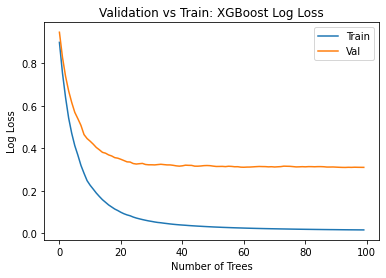

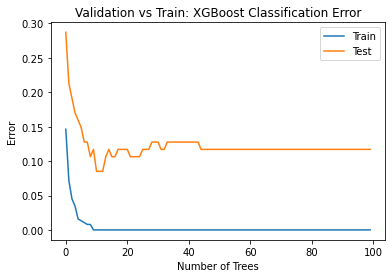

In [206]:
skf = StratifiedKFold(n_splits=4, random_state=42, shuffle = True)

xgb_cl = xgb.XGBClassifier(eval_metric =  "mlogloss", use_label_encoder = False)

test_scores_xgb = []
y_test_ar = []
pred_scores = []

for train_index, other_index in skf.split(X1, label_encoded_y):
    #split into train and other
    X_train, X_other = X1.iloc[train_index], X1.iloc[other_index]
    y_train, y_other = label_encoded_y[train_index], label_encoded_y[other_index]
    #split into validation and test
    for val_index, test_index in skf.split(X_other,y_other):
        X_val, X_test = X1.iloc[val_index], X1.iloc[test_index]
        y_val, y_test = label_encoded_y[val_index], label_encoded_y[test_index]
        
        #apply transformer
        X_train_prep = preprocess.fit_transform(X_train)
        X_val_prep = preprocess.transform(X_val)
        X_test_prep = preprocess.transform(X_test) 

        # Convert our data into XGBoost format
        d_train = xgb.DMatrix(X_train_prep, label = y_train)
        d_valid = xgb.DMatrix(X_val_prep, label = y_val)
        d_test = xgb.DMatrix(X_test_prep,label = y_test)

        # Fit
        evaluated=[(X_train_prep, y_train), (X_val_prep, y_val)]
        xgb_cl.fit(X_train_prep,y_train, 
                   eval_metric=["merror", "mlogloss"], 
                   eval_set = evaluated, 
                   early_stopping_rounds = 200,
                   verbose = False)
        
        # Predict
        preds = xgb_cl.predict(X_test_prep)
        y_test_ar.append(np.asarray(y_test))
        pred_scores.append(preds)
        test_scores_xgb.append(balanced_accuracy_score(y_test, preds))
        print('validation accuracy', balanced_accuracy_score(y_val, xgb_cl.predict(X_val_prep)))
        print('test accuracy', balanced_accuracy_score(y_test, preds))
        plot_error()


In [207]:
print('Balanced Accuracy:',np.around(np.mean(test_scores_xgb),2),'+/-',np.around(np.std(test_scores_xgb),2))

print("test:   ", balanced_accuracy_score(y_test, preds))

Balanced Accuracy: 0.85 +/- 0.08
test:    0.8455026455026454


Now let's try to tune the hyperparameters and try the process again.

We're susicious of xgboost improved accuracy. One way that we can get an idea of what's going on is to print confusion matrices. We can see what's improving with the xgboost model. Print confusion matrix -> e.g. take knn and gradient on single runs at same random states. Is a single class or overall that's working? 

#### Confusion Matrix for Different Model 

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [42]:
print(len(pred_log[0]))
print(len(pred_log[1]))

125
125


##### Logistic Confusion Matrix

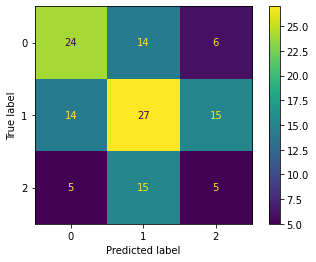

In [44]:
cm_log = confusion_matrix(pred_log[0],pred_log[1])
'''values equal to:
   TN  FP
   FN  TP'''
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp.plot() #display the confusion matrix

##### Random Forest Confusion Matrix

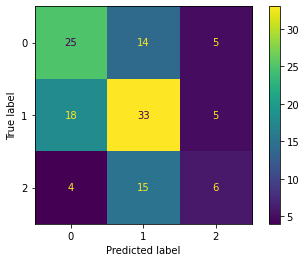

In [45]:
cm_rf = confusion_matrix(pred_rf[0],pred_rf[1])
'''values equal to:
   TN  FP
   FN  TP'''
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot() #display the confusion matrix

##### K-Nearest Neighbors Confusion Matrix

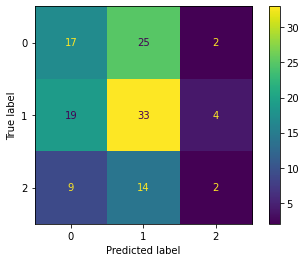

In [46]:
cm_knn = confusion_matrix(pred_knn[0],pred_knn[1])
'''values equal to:
   TN  FP
   FN  TP'''
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot() #display the confusion matrix

##### XGBoost Confusion Matrix

In [47]:
xgb_preds = []
for i in range(0,len(pred_scores)):
    for j in range(0,len(pred_scores[i])):
        xgb_preds.append(pred_scores[i][j])

xgb_ys = []
for i in range(0,len(y_test_ar)):
    for j in range(0,len(y_test_ar[i])):
        xgb_ys.append(y_test_ar[i][j])


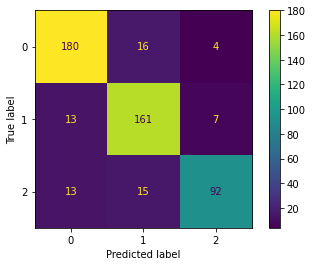

In [49]:
cm_xgb = confusion_matrix(xgb_ys,xgb_preds)

'''values equal to:
   TN  FP
   FN  TP'''
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot() #display the confusion matrix

The most common class is the currently married category. When encoded, this is label number 1. In the models before xgboost, the most populous class was predicted more often. This was the source of most of the errors that we see in the confusion matrices. XGBoost minimizes this class 1 error so that class 2 and class 0 are categorized correctly. 

NOTE: 0 = never married , 1 = currently married, 2=previously married

### Try Tuning XGBoost Hyperparameters
NOTES: plots of overfitting and underfitting determined early stopping value

In [201]:
'''
This function splits the data through stratified kfold splitting. it usess a preprocessor defined
above to traverse the hyperparameters and find the best model given the accuracy score with xgboost. 
'''

test_scores_xgb = []
final_models = []
best_params = []

param_grid = {
        "max_depth": [1, 10, 20, 30, 100 , 300],
        "learning_rate": [0.05],
        'reg_alpha': [0, 0.01, 0.1, 1, 10, 100],
        'reg_lambda': [0, 0.01, 0.1, 1, 10, 100]
    }

#init splitter
splitter = StratifiedKFold(n_splits=4,shuffle=True, random_state = 42)



for train_index, other_index in splitter.split(X1, label_encoded_y):
    
    #split into train and other
    X_train, X_other = X1.iloc[train_index], X1.iloc[other_index]
    y_train, y_other = label_encoded_y[train_index], label_encoded_y[other_index]

    #split into validation and test
    for val_index, test_index in splitter.split(X_other,y_other):
        X_val, X_test = X1.iloc[val_index], X1.iloc[test_index]
        y_val, y_test = label_encoded_y[val_index], label_encoded_y[test_index]

        #apply transformer
        X_train_prep = preprocess.fit_transform(X_train)
        X_val_prep = preprocess.transform(X_val)
        X_test_prep = preprocess.transform(X_test) 

        # we save the train and validation scores
        # the validation scores are necessary to select the best model 
        #we save the train score just to check things
        train_score = np.zeros(len(ParameterGrid(param_grid))) 
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []

        # loop through all combinations of hyperparameter combos
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            print(' ',params)
            # Init classifier
            xgb_cl = xgb.XGBClassifier(**params,
                                       objective="multi:softprob",
                                       eval_metric =  "mlogloss", 
                                       use_label_encoder = False)
    
            # fit the model
            evaluated_on=[(X_train_prep,y_train), (X_val_prep,y_val)]
            xgb_cl.fit(X_train_prep, y_train,
                       early_stopping_rounds = 60, 
                       eval_set = evaluated_on,
                       verbose = False)


            models.append(xgb_cl) # save it
            # calculate train and validation accuracy scores 
            y_train_pred = xgb_cl.predict_proba(X_train_prep) 
            train_score[p] = log_loss(y_train,y_train_pred) 
            y_val_pred = xgb_cl.predict_proba(X_val_prep)
            val_score[p] = log_loss(y_val,y_val_pred) 
            print(' ',train_score[p],val_score[p])
            
        # print out model parameters that minimize validation loss
        print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score)])
        best_params.append(ParameterGrid(param_grid)[np.argmin(val_score)])
        print('corresponding validation score (loss):',np.min(val_score))
        # collect and save the best model 
        final_models.append(models[np.argmin(val_score)])
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test_prep) 
        test_scores_xgb.append(balanced_accuracy_score(y_test,y_test_pred)) 
        #print('test score:',test_scores[i]) 
     

  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8903695902824402 0.9889599639684596
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8904329723914465 0.9889792698494931
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8910504611730575 0.9898272904943912
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8968295170068741 0.9972083064469885
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.9478277447223663 1.0081393677503505
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.9584105655352274 1.0173613162750894
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.8904929792881012 0.9894616749692471
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.8905618539651234 0.9896381953929333
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 1, 'learn

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.04910018210609754 0.3923441311740812
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.05794260330994924 0.3912957142642204
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.055548575709263484 0.39838934638240237
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.08582055148979029 0.4104877410337646
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.25900704196095464 0.5311527224455742
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.7170171184539795 0.8361548061700578
  {'reg_la

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.04910018210609754 0.3923441311740812
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.05794260330994924 0.3912957142642204
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.055548575709263484 0.39838934638240237
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.08582055148979029 0.4104877410337646
  {'

  0.7395705893834432 0.8556258424799493
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.8817669984499613 0.9450480525797986
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
best model parameters: {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
corresponding vali

  0.7360385966300964 0.8392230671771029
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.7380004714727402 0.8403056680839113
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.7347737214167913 0.8369519331670822
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.7357141998608907 0.8368897934226279
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.751463626742363 0.8447254810561525
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.8849046365420024 0.9464627472644157
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_l

  0.18599123880267143 0.4630388383694152
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.3381756999095281 0.5451778203566023
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.7440977209409078 0.8443552208073596
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7206825682322184 0.8250406043643647
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7205670734246572 0.8275729931415395
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7212290445566177 0.8264236191802836
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7212130929629008 0.8250551561408854
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7395705893834432 0.8369729106730603
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.8817669984499613 0.9397865857215638
  {'reg_lambda

  0.16048479124903678 0.4512765975074565
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.16025402091443539 0.4459113460034132
  {'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.16219045763711135 0.44756760380845123
  {'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.18599123880267143 0.4630388383694152
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.3381756999095281 0.5451778203566023
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.7440977209409078 0.8443552208073596
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7206825682322184 0.8250406043643647
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7205670734246572 0.8275729931415395
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7212290445566177 0.8264236191802836
  {

  0.06378593036780755 0.3067409084227524
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
  0.09134406507015229 0.3158854980217783
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
  0.2686946055293083 0.46207891600696666
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
  0.7244587245782217 0.8008481314307765
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.16097702056666216 0.37857891438823
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.15961826183398564 0.37612219515599704
  {'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.1630847227672736 0.381486996224052
  {'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.1861605940858523 0.4070340826323158
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.34021476658185323 0.5035193432318537
  {'reg_lambd

  0.7176312839984894 0.7936867428453345
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.05677974826594194 0.29747168608009816
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.057285808722178144 0.3090024181886723
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.06105808131148418 0.3157795686274767
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.09103362432618936 0.3084702494113069
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.2668013464907805 0.45790674145284455
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.7202597454388936 0.7964815880122937
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.16048479124903678 0.3766645164081925
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.16025402091443539 0.37018054308075654

  0.05098972252756357 0.2953510623425245
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.08223565422495206 0.31946821400993747
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.2594997136990229 0.45308782975924644
  {'reg_lambda': 100, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.7176312839984894 0.7936867428453345
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.05677974826594194 0.29747168608009816
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.057285808722178144 0.3090024181886723
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.06105808131148418 0.3157795686274767
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.09103362432618936 0.3084702494113069
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.2668013464907805 0.457

  0.2599897232254346 0.5118602792683401
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.7216104653676351 0.8206654812160291
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.06642631319661935 0.3832952767414482
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.06442759030560652 0.3876393131715687
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.05736712129662434 0.39084589651932844
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.08533887221415838 0.40227792037552906
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.2610354448954264 0.5141351789236068
  {'reg_lambda': 100, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.7219633844693502 0.8215943948218697
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
  0.057671361391743024 0.40620007934

  0.05794260330994924 0.3904942127630899
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.05149562047918638 0.3936036504805088
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.08582055148979029 0.4094666503761944
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.25900704196095464 0.5142988959425374
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.7170171184539795 0.8139030522421786
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.0596866059054931 0.3920122405416087
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.051302395279208816 0.4050735525002605
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.05924667691191037 0.4045501680162392
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.08328756505250931 0.412326037373982
  {

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.05058402440696955 0.3879661775733295
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.05794260330994924 0.3904942127630899
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.05149562047918638 0.3936036504805088
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.08582055148979029 0.4094666503761944
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.25900704196095464 0.5142988959425374
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.7170171184539795 0.8139030522421786
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.0596866059054931 0.3920122405416087
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.051302395279208816 0.4050735525002605


  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.07240148694650765 0.44399152047211127
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.0801427865826941 0.44519070571949404
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.05946546848467056 0.4357362605471124
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.08698088551891293 0.44410057486064974
  {'reg_lamb

  0.7909680882349928 0.881072429239109
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.8929470737088234 0.9487030906702882
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.07451467628174639 0.44779829372481633
  {'reg_

  0.778756095572038 0.8785571965479082
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 100, 'learning_rate': 0.05}
  0.7785012932058345 0.8783521472766835
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 100, 'learning_rate': 0.05}
  0.7787228095880214 0.8776884479548341
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 100, 'learning_rate': 0.05}
  0.7909680882349928 0.881072429239109
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 100, 'learning_rate': 0.05}
  0.8929470737088234 0.9487030906702882
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'

  0.9158497186417275 0.958450475271712
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9280126594165539 0.9666979763102024
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9670643644764069 0.9903688760513955
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9696902989390048 0.9949941736586551
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9696966435046906 0.994983953998444
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9697142424101525 0.9950031073803597
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9699054051269876 0.9950387890034533
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9722897178949194 0.9961674054886432
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.992057536193665 1.0092073000491935
  {'reg_lambda': 0, 'reg_a

  0.16198779186828338 0.44944086694654
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.16176572929512947 0.4516657399845884
  {'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.16416599719408662 0.44347350949302633
  {'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.18798654251038394 0.4539185296347801
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.3471058536162402 0.5790098831057549
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.7562884051114955 0.8608703749611023
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.7794938310980797 0.8874992008538957
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.7803281015379632 0.8857795887805046
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.7810247692259702 0.8888945785608697
  {'reg_lambd

  0.09332063371077814 0.3869353933061691
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.2729849124802871 0.5124510479100207
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.7331285554360836 0.8442463297793206
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.16198779186828338 0.44944086694654
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.16176572929512947 0.4516657399845884
  {'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.16416599719408662 0.44347350949302633
  {'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.18798654251038394 0.4539185296347801
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.3471058536162402 0.5790098831057549
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.7562884051114955 0.8608703749611023
  {'r

  0.9641497789862308 0.9769147120891734
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9036071727726054 0.955143836267451
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9036706367388685 0.9552668935440957
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9041390254935051 0.9562922538594997
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.907626526152834 0.9594964752805993
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9231649017397393 0.9633389644800349
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.964871290516346 0.9770155587094895
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9137537249542297 0.9609332090996682
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9137876869199124 0.9609678127664201
  {'reg_lambda': 0.1

  0.094866440036988 0.501942399374031
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.2657374516525801 0.6039466468736212
  {'reg_lambda': 100, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.7310466550766154 0.8553822411501661
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.08308501667442157 0.5179659115903555
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.08255735625255298 0.5322663908467647
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.07994749687830026 0.5075334564961017
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.10337287628468364 0.5072601716172822
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.2729849124802871 0.6049049637736158
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.7331285554360836 0.8576780925405786
 

  0.06233956518662261 0.5256538855189339
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.06519584936347414 0.5300229153734572
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.06936865638287619 0.5211414236654627
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.094866440036988 0.501942399374031
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.2657374516525801 0.6039466468736212
  {'reg_lambda': 100, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.7310466550766154 0.8553822411501661
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.08308501667442157 0.5179659115903555
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.08255735625255298 0.5322663908467647
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.07994749687830026 0.507

  0.9030605079804329 1.0165235425563568
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.906734400131601 1.0193586508010297
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.9219341435806548 1.0242018854998527
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.9641206976264081 1.0501858382783038
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.9025649204850197 1.0161937037681013
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.902622031880186 1.0160567113693724
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.9031655877194507 1.0165996053751478
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.9068243498022251 1.0199710206782564
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.9219892374537093 1.0242564960363063
  {'reg_lambda': 1

  0.07289346355072995 0.4910627254383995
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.05894236625766659 0.4789261928303762
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.06534726452082396 0.48252626748240374
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.09664257577660078 0.4713446452341815
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.2645211118927344 0.5762272412948152
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.7307244135027237 0.869121530905683
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.06233956518662261 0.4891063254326582
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.07050383781538681 0.4829564514233077
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.06936865638287619 0.47760663276657145
  

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.07289346355072995 0.4910627254383995
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.05894236625766659 0.4789261928303762
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.06534726452082396 0.48252626748240374
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.09664257577660078 0.4713446452341815
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.2645211118927344 0.5762272412948152
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.7307244135027237 0.869121530905683
  {'reg

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
best model parameters: {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
corresponding validation score (loss): 0.4513512784813313
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8702975505209983 0.9921770776792239
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8703878736321596 0.9922313568412616
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.87116976

  0.760618519037962 0.8606325605864166
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.7664418267284302 0.8656707883522075
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.8621077558937225 0.9490895027755409
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_

  0.7513954921605739 0.8559562637600847
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7491564294917786 0.8539461890856425
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7501066690905297 0.8549719142016544
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7500591369226892 0.8534525950108806
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7565580964722531 0.8578989544222432
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.8609817157241892 0.9480226225750421
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_

  0.18629077278037973 0.39640712641900583
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.34394006730314897 0.5184474410389059
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.736206897157938 0.8430299698024668
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7513954921605739 0.8559562637600847
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7491564294917786 0.8539461890856425
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7501066690905297 0.8549719142016544
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7500591369226892 0.8534525950108806
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7565580964722531 0.8578989544222432
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.8609817157241892 0.9480226225750421
  {'r

  0.7177022151014907 0.7759031821438607
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.16220576928908678 0.3513211928942102
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.163036682811427 0.35528128324670993
  {'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.16595033616659807 0.3581111946717856
  {'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.19089739183162122 0.3792681572364366
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.35014413142616446 0.49309119328539425
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 10, 'learning_rate': 0.05}
  0.7386000778605329 0.7947941606349134
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.7579692799518717 0.8150042038648686
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 10, 'learning_rate': 0.05}
  0.7580374932669579 0.8150576701823701
  {'reg_lambda

  0.06206386937621109 0.2824287227295498
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.09199677235843177 0.30824604781067116
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.27120053429315066 0.4311443849446926
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.7143585914944081 0.777853491141441
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.16048821408618638 0.3510073333027515
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.16167001865625857 0.3506619281908299
  {'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.16405701574849638 0.3475963075427299
  {'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.18629077278037973 0.3647519732884904
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 30, 'learning_rate': 0.05}
  0.34394006730314897 0.4914554129255579
  {'reg_l

  0.7120284346189905 0.7764795004053319
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.05765628888509534 0.2788871448645566
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.05835576619001779 0.2914665140845674
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.06206386937621109 0.2824287227295498
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.09199677235843177 0.30824604781067116
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.27120053429315066 0.4311443849446926
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 300, 'learning_rate': 0.05}
  0.7143585914944081 0.777853491141441
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.16048821408618638 0.3510073333027515
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 300, 'learning_rate': 0.05}
  0.16167001865625857 0.35066192819

  0.05303849583551129 0.2615636028745707
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.05775753495858071 0.25040373903639773
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.08751999293057684 0.2760085627991468
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.2679767026367815 0.39793488549742295
  {'reg_lambda': 100, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
  0.7153101498459248 0.7845866917929751
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
  0.060697479896802214 0.24606560836447047
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
  0.06152456851695922 0.2603949810516961
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
  0.06560490833486411 0.2552422256942125
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
  0.0944786556114621 0.273827293

  0.26313765570917663 0.39661841126198466
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.7117291975845682 0.7829611634320401
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.04874413157317867 0.2813064020642258
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.04905982370032592 0.2588672523010284
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.05251030399503701 0.2525143071097579
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.0844472551252693 0.26233021148103985
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.2643080243761552 0.39759783652868674
  {'reg_lambda': 100, 'reg_alpha': 0.01, 'max_depth': 30, 'learning_rate': 0.05}
  0.7120284346189905 0.7832700001432541
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 30, 'learning_rate': 0.05}
  0.05765628888509534 0.24844261328

  0.04966337149318783 0.2652477973953207
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.051269702078338635 0.25849330305379437
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.08387097218470212 0.26050514662440155
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.26313765570917663 0.39661841126198466
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.7117291975845682 0.7829611634320401
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.04874413157317867 0.2813064020642258
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.04905982370032592 0.2588672523010284
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.05251030399503701 0.2525143071097579
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 300, 'learning_rate': 0.05}
  0.0844472551252693 0.26233021

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.052344417672584506 0.35666786471104367
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.052512072423037064 0.3650376585094219
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.056168574889368834 0.368361370697459
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.08701647340042636 0.3467207857744491
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.266526228966231 0.46376533211862786
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
  0.714899764812373 0.8051124440228685
  {'reg_lambd

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 20, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.04712792932045983 0.3626069852170792
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.051751500934342595 0.3625892246776122
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.05340445346070176 0.34226887978296333
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 30, 'learning_rate': 0.05}
  0.08387097218470212 0.33905081512366836
  {'reg

  0.7565580964722531 0.8309737383685214
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 100, 'learning_rate': 0.05}
  0.8609817157241892 0.9245675237888985
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 100, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 300, 'learning_rate': 0.05}
  0.04712792932045983 0.3626069852170792


  0.9491794781481966 1.0192052363067545
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9491827755849412 1.0192036590268534
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9492079639371406 1.0192230664273745
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9486934913599745 1.01926197736494
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9513846193539336 1.020347022882072
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 1, 'learning_rate': 0.05}
  0.9726874184735278 1.03225480036069
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 1, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, '

  0.18523090854881608 0.43682444035526247
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.34599348954222303 0.5690703745330533
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.7448489967178791 0.8539037550649335
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.7453836934601373 0.8722342392129283
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.7450133636197511 0.872073969052684
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.7458517931084684 0.87491712038235
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.7470370476391721 0.8742592913168733
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.7551490607017532 0.8759933998507838
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 20, 'learning_rate': 0.05}
  0.8780437314763982 0.96063506731423
  {'reg_lambda': 

  0.15987338043471916 0.4308105165198926
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.160461288292278 0.43164439126849174
  {'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.16335585697534236 0.4276326828265703
  {'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.18523090854881608 0.43682444035526247
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.34599348954222303 0.5690703745330533
  {'reg_lambda': 100, 'reg_alpha': 1, 'max_depth': 100, 'learning_rate': 0.05}
  0.7448489967178791 0.8539037550649335
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 100, 'learning_rate': 0.05}
  0.7453836934601373 0.8722342392129283
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 100, 'learning_rate': 0.05}
  0.7450133636197511 0.872073969052684
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 100, 'learning_rate': 0.05}
  0.7458517931084684 0.87491712038235
  {'re

  0.8909474091326937 0.9168473976723691
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.8942525257614065 0.9210472122785893
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9086443754903814 0.93230783432088
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9449099253149743 0.9641098411793404
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.8999663212514938 0.9239839816347082
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.8999916197771721 0.9238294546908521
  {'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9003132250397763 0.9241423803441068
  {'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9024799592158896 0.9254553879195071
  {'reg_lambda': 10, 'reg_alpha': 1, 'max_depth': 1, 'learning_rate': 0.05}
  0.9137283191084862 0.9363958699272034
  {'reg_lambda': 100, 'reg_

  0.719238882448445 0.7968832194171054
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.062283661865450916 0.33255808645898993
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.06540491947646629 0.3420991845072267
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.06310469602690415 0.33626328632631836
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.09299435544303282 0.36897483192622027
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.27242012623142686 0.475092952159491
  {'reg_lambda': 100, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
  0.7217050848647635 0.7994727660366829
  {'reg_lambda': 0, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.15987338043471916 0.4115844881360201
  {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 20, 'learning_rate': 0.05}
  0.160461288292278 0.4140150426153807
  

  0.05296490662681692 0.3173823207616806
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.08431762603032304 0.37681799037183855
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.2653008822470586 0.46797341774118706
  {'reg_lambda': 100, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.719238882448445 0.7968832194171054
  {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.062283661865450916 0.33255808645898993
  {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.06540491947646629 0.3420991845072267
  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.06310469602690415 0.33626328632631836
  {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.09299435544303282 0.36897483192622027
  {'reg_lambda': 10, 'reg_alpha': 0.1, 'max_depth': 100, 'learning_rate': 0.05}
  0.27242012623142686 0.4

  0.8933277112689424 0.9738901790152205
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.908611712699875 0.9839645338819382
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.9446282118875929 1.0030918730066178
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.8893122661938059 0.9717619415927441
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.8895132138215481 0.9719509777236492
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.8900002376671802 0.9724931412554801
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.8934094746537665 0.9733718037605286
  {'reg_lambda': 10, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.9081167265614296 0.9836115761006132
  {'reg_lambda': 100, 'reg_alpha': 0.01, 'max_depth': 1, 'learning_rate': 0.05}
  0.944654866894509 1.003103717844537
  {'reg_lambda

  0.0742552267050648 0.4142917619344402
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.06940945404324125 0.40724576056558404
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.08947427194823135 0.4708660810868791
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.26529749082599546 0.5302473967696758
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.7190302637346248 0.8164821124457299
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.08158509002780502 0.41233859674886186
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.06709190399108574 0.41166883177976027
  {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.05296490662681692 0.4114668790171755
  {'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
  0.08543955363293594 0.46184503251409276

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.07257987641075507 0.41556219296886565
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.0742552267050648 0.4142917619344402
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.06940945404324125 0.40724576056558404
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.08947427194823135 0.4708660810868791
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.26529749082599546 0.5302473967696758
  {'reg_lambda': 100, 'reg_alpha': 0, 'max_depth': 100, 'learning_rate': 0.05}
  0.7190302637346248 0.8164821124457299
  {'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.08158509002780502 0.41233859674886186
  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 100, 'learning_rate': 0.05}
  0.06709190399108574 0.411668831779760

  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
best model parameters: {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
corresponding validation score (loss): 0.40724576056558404
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8892168680879664 0.9650552545456176
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8892529357938056 0.9652838681606536
  {'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8898748087280608 0.965912050389229
  {'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.8933277112689424 0.9678679045210493
  {'reg_lambda': 10, 'reg_alpha': 0, 'max_depth': 1, 'learning_rate': 0.05}
  0.9080630934777412 

  0.8821543768999425 0.9540553498775401
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 100, 'reg_alpha': 100, 'max_depth': 10, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.06606949579981254 0.32166302822371745
  {'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
  0.05876497573595732 0.31974009553247945
  {'r

  0.7458517931084684 0.8560531735420227
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7470370476391721 0.8568549541399834
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.7551490607017532 0.8637001863185395
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 30, 'learning_rate': 0.05}
  0.8780437314763982 0.9517044114305618
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.1, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 1, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 10, 'reg_alpha': 100, 'max_depth': 30, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_la

  0.7448489967178791 0.8402403073107942
  {'reg_lambda': 0, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7453836934601373 0.8540421526165719
  {'reg_lambda': 0.01, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7450133636197511 0.8538198903837102
  {'reg_lambda': 0.1, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7458517931084684 0.8560531735420227
  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7470370476391721 0.8568549541399834
  {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.7551490607017532 0.8637001863185395
  {'reg_lambda': 100, 'reg_alpha': 10, 'max_depth': 300, 'learning_rate': 0.05}
  0.8780437314763982 0.9517044114305618
  {'reg_lambda': 0, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {'reg_lambda': 0.01, 'reg_alpha': 100, 'max_depth': 300, 'learning_rate': 0.05}
  1.0986123085021973 1.0986123085021973
  {

In [210]:
# save the output to be used later
import pickle
file = open('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/results/xgb_hyptune.save', 'wb')
pickle.dump((final_models,best_params,test_scores_xgb),file)

file.close()

In [12]:
import pickle
file = open('/users/ktoleary.13/Desktop/DATA1030_Proj/mach_rel_classification/results/xgb_hyptune.save','rb') 
final_models,best_params,test_scores_xgb = pickle.load(file) 
file.close()

In [211]:
#print out the best parameter for each run
for i in best_params:
    print(i)
test_scores_xgb

{'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
{'reg_lambda': 0.1, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
{'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
{'reg_lambda': 0, 'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.05}
{'reg_lambda': 0.01, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
{'reg_lambda': 1, 'reg_alpha': 0.01, 'max_depth': 20, 'learning_rate': 0.05}
{'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
{'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 10, 'learning_rate': 0.05}
{'reg_lambda': 0.01, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
{'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
{'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 10, 'learning_rate': 0.05}
{'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 20, 'learning_rate': 0.05}
{'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth': 20, 'learning_rate': 0.05}
{'re

[0.8857142857142857,
 0.8736772486772487,
 0.7047619047619048,
 0.9259259259259259,
 0.8005698005698006,
 0.7804232804232804,
 0.9410256410256411,
 0.7634920634920634,
 0.9248366013071895,
 0.883838383838384,
 0.7393939393939394,
 0.9696969696969697,
 0.8679653679653679,
 0.7999999999999999,
 0.9296296296296296,
 0.8455026455026454]

In [209]:
print('Balanced Accuracy:',np.around(np.mean(test_scores_xgb),2),'+/-',np.around(np.std(test_scores_xgb),2))

Balanced Accuracy: 0.85 +/- 0.08


In [222]:
#print the most frequent of the best parameters
from scipy import stats 

def most_freq(param_name):
    count = []
    for items in best_params:
        count.append(items[param_name])
    mode_i = stats.mode(count)
    print('mode of', param_name, mode_i[0])

param_ls = ["max_depth", "learning_rate", 'reg_alpha', 'reg_lambda']
    
[most_freq(name) for name in param_ls]

mode of max_depth [20]
mode of learning_rate [0.05]
mode of reg_alpha [0.]
mode of reg_lambda [0.1]


[None, None, None, None]

In [19]:
#QUICKLY DEFINE THE SPLITS, AND ALGORITHM (in case I want to access splits)
xgb_cl = xgb.XGBClassifier(max_depth =20, 
                           learning_rate = 0.05,
                           reg_alpha = 0., 
                           reg_lambda = 0.1,
                           objective="multi:softprob",
                           eval_metric =  "mlogloss", 
                           use_label_encoder = False)

splitter = StratifiedKFold(n_splits=4,shuffle=True, random_state = 42)

#generate data splits
for train_index, other_index in splitter.split(X1, label_encoded_y):
    #split into train and other
    X_train, X_other = X1.iloc[train_index], X1.iloc[other_index]
    y_train, y_other = label_encoded_y[train_index], label_encoded_y[other_index]

    #split into validation and test
    for val_index, test_index in splitter.split(X_other,y_other):
        X_val, X_test = X1.iloc[val_index], X1.iloc[test_index]
        y_val, y_test = label_encoded_y[val_index], label_encoded_y[test_index]

        #apply transformer
        X_train_prep = preprocess.fit_transform(X_train)
        X_val_prep = preprocess.transform(X_val)
        X_test_prep = preprocess.transform(X_test) 

### Feature Importance on Dummy Sets
Here, I'm just playing around with feature importances. However, one important discovery is that the same features are considered important and the sam features are considered unimportant for each type of global importance. 

Use the below references:

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7 

https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9

In [21]:
xgb_sample1 = xgb.XGBClassifier(objective="multi:softprob",
                               eval_metric =  "mlogloss", 
                               use_label_encoder = False,
                               random_state=1,
                              importance_type = 'cover')

xgb_sample2 = xgb.XGBClassifier(objective="multi:softprob",
                               eval_metric =  "mlogloss", 
                               use_label_encoder = False,
                               random_state=1,
                              importance_type = 'gain')

xgb_sample3 = xgb.XGBClassifier(objective="multi:softprob",
                               eval_metric =  "mlogloss", 
                               use_label_encoder = False,
                               random_state=1,
                              importance_type = 'weight')

clf = Pipeline(steps=[('preprocessor', preprocess)])


In [52]:
#COLLECT FEATURE NAMES OF FIT TRANSFORM AND TRAIN EACH MODEL W/ DIFF GLOBAL FEATURE IMPORTANCES
sampleX = preprocess.fit_transform(X_train)
model1 = xgb_sample1.fit(sampleX, y_train)
model2 = xgb_sample2.fit(sampleX, y_train)
model3 = xgb_sample3.fit(sampleX, y_train)
#collect features names after the preprocessing
feature_names = list(clf.named_steps['preprocessor'].transformers_[0][1].get_feature_names(onehot_ft)) + \
clf.named_steps['preprocessor'].transformers_[1][-1] + clf.named_steps['preprocessor'].transformers_[2][-1]

In [96]:
# Convert our data into XGBoost format
d_train = xgb.DMatrix(X_train_prep, label = y_train)
d_valid = xgb.DMatrix(X_val_prep, label = y_val)
d_test = xgb.DMatrix(X_test_prep,label = y_test)


# Create the DMatrix: housing_dmatrix
matrix = xgb.DMatrix(data=sampleX, label=y_train)

X_train = pd.DataFrame(data=matrix, columns=feature_names)
dtrain = xgb.DMatrix(data = X_train, label=y_train)
xgb_sample1.fit(d_train, y_train)

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)
# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}
# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)
# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()


NameError: name 'X_train_prep' is not defined

In [23]:
#print shape and save each array of feature importances (displayed as fraction feature contributes)
print(sampleX.shape)
fimport1 = (model1.feature_importances_)
fimport2 = (model2.feature_importances_)
fimport3 = (model3.feature_importances_)

(376, 104)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

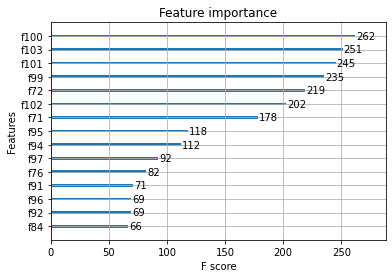

In [56]:
xgb.plot_importance(xgb_sample1.get_booster(), max_num_features = 15)

In [108]:
#check that the number of important features are the same
def remove_zeros(impor):
    #return the index of featues with non-zero importances
    return [i for i,v in enumerate(impor) if v == 0]

def imp_index(impor):
    #return the index of featues with non-zero importances
    return [i for i,v in enumerate(impor) if v != 0]

print(remove_zeros(fimport1) == remove_zeros(fimport2))
remove_zeros(fimport2) == remove_zeros(fimport3)

#the same features are non-zero important across all global methods
ft_nm = np.array(feature_names)
#asdf = np.concatenate((fimport1.T,ft_nm.T), axis = 1)
arr = ft_nm[:, np.newaxis]
arr2 = fimport1[:, np.newaxis]
np.hstack((arr,arr2))

True


array([['race_0', '0.0'],
       ['race_10', '0.023283133'],
       ['race_20', '0.0'],
       ['race_30', '0.01503881'],
       ['race_50', '0.0'],
       ['race_60', '0.009264776'],
       ['race_70', '0.031638604'],
       ['voted_0', '0.0'],
       ['voted_1', '0.0085204765'],
       ['voted_2', '0.013457856'],
       ['familysize_0', '0.0'],
       ['familysize_1', '0.01572333'],
       ['familysize_2', '0.004381542'],
       ['familysize_3', '0.004906772'],
       ['familysize_4', '0.003997434'],
       ['familysize_5', '0.0283807'],
       ['familysize_6', '0.020426732'],
       ['familysize_7', '0.0'],
       ['familysize_8', '0.0'],
       ['familysize_9', '0.0'],
       ['familysize_15', '0.0'],
       ['urban_0', '0.053043168'],
       ['urban_1', '0.013460992'],
       ['urban_2', '0.0046244552'],
       ['urban_3', '0.0073943674'],
       ['gender_0', '0.0'],
       ['gender_1', '0.017341891'],
       ['gender_2', '0.0019468896'],
       ['gender_3', '0.0'],
       ['engna

The same features are non-zero important across all global methods. This means that when we are looking at feature importances for the entire run on the dataset, we can just use the feature names from one and apply them to the other vectors to get the associated names. 

In [30]:
#count the number of important features are print the values associated with each importance model
count = 0 

for i , value in enumerate(fimport1):
    if value > 0.00:
        #print(feature_names[i], value, fimport2[i], fimport3[i])
        if (value + fimport2[i] + fimport3[i]) > 0.05:
            print(feature_names[i], value + fimport2[i] + fimport3[i])


familysize_5 0.06862911
familysize_6 0.0575509
urban_0 0.11425321
orientation_3 0.09985367
hand_3 0.06473585
religion_8 0.06955531
voc_conf_8 0.05753328
Mscore 0.069692194
age 0.113251984
extraver 0.05209302
agreeable 0.058289852
testelapse 0.08446157
PITtime 0.089803696
NITtime 0.08821911
PVHtime 0.07108833
CVHtime 0.086117305


Text(0.5, 0, 'Xgboost Feature Importance')

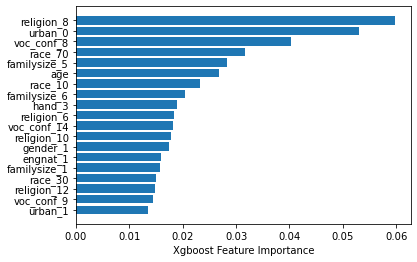

In [127]:
ft_nm = np.array(feature_names)

sorted_idx = xgb_sample1.feature_importances_.argsort()
top_20 = sorted_idx[84:-1]
plt.barh(ft_nm[top_20], xgb_sample1.feature_importances_[top_20])
plt.xlabel("Xgboost Feature Importance")